In [1]:
from collections import defaultdict

import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
env = gym.make('Blackjack-v1', natural=True, render_mode="rgb_array")

In [3]:
print(env.observation_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))


In [4]:
print(env.action_space)

Discrete(2)


### Визуализация постоянного добирания

In [5]:
def plot_env(env):
    env_screen = env.render()
    fig = plt.figure(figsize=(10, 10), dpi=40)
    ax = fig.add_subplot() 
    ax.imshow(env_screen, interpolation=None)
    plt.axis("off")
    plt.grid(visible=None)
    plt.show()

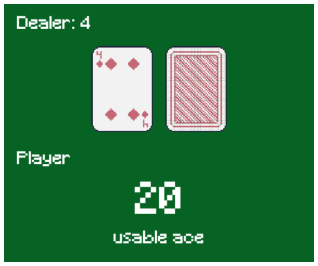

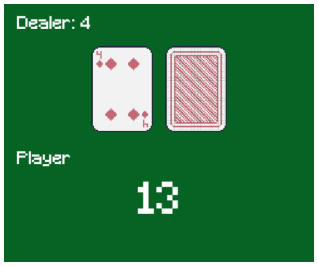

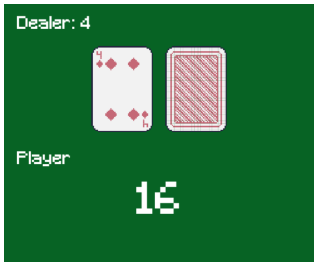

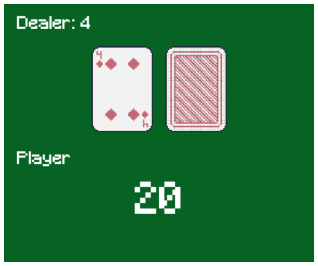

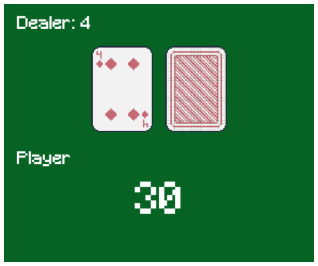

In [6]:
state = env.reset()
plot_env(env)
done = False
while True:
    action = 1
    new_state, reward, done, a, b = env.step(action)
    plot_env(env)
    if done:
        break

## Часть первая, с блекджеком и стратегиями

#### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [7]:
def game_episode_simple_strategy(env):
    state = env.reset()[0]
    done = False
    all_states, all_actions, all_rewards = [], [], []
    while True:
        action = 1 if state[0] < 19 else 0
        new_state, reward, done, a, b = env.step(action)
        all_states.append(state)
        all_actions.append(action)
        all_rewards.append(reward)
        state = new_state
        if done:
            break
    return all_states, all_actions, all_rewards

In [8]:
game_episode_simple_strategy(env)

([(16, 5, False), (18, 5, False)], [1, 1], [0.0, -1.0])

In [9]:
def get_G(rewards, gamma):
    n = len(rewards)
    G = [0 for _ in range(n)]
    G[n - 1] = rewards[n - 1]
    for i in range(n - 2, -1, -1):
        G[i] = rewards[i] + gamma * G[i + 1]
    return G

#### Здесь нам не нужен first visit, потому что в данной игре в одном эпизоде в одно состояние мы не попадаем

In [10]:
def monte_carlo(n_episodes, gamma):
    N = defaultdict(lambda: np.zeros(2))
    returns_sum = defaultdict(lambda: np.zeros(2))
    Q = defaultdict(lambda: np.zeros(2))

    for _ in range(n_episodes):
        states, actions, rewards = game_episode_simple_strategy(env=env)
        G = get_G(rewards=rewards, gamma=gamma)
        for i in range(len(states)):
            state = states[i]
            action = actions[i]
            N[state][action] += 1
            returns_sum[state][action] += G[i]
            Q[state][action] = returns_sum[state][action] / N[state][action]
    return Q

In [11]:
Q = monte_carlo(n_episodes=100000, gamma=1)

In [12]:
V = defaultdict(lambda:0, dict((key, val[1] if key[0] < 19 else val[0]) for key, val in Q.items()))

In [13]:
def plot3d(V):
    def get_figure(usable_ace, ax):
        x_range = np.arange(3, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([V[x, y, usable_ace] for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis')
        ax.set_xlabel('Hero points')
        ax.set_ylabel('Dealer points')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 30))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('With Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('Without Usable Ace')
    get_figure(False, ax)
    plt.show()

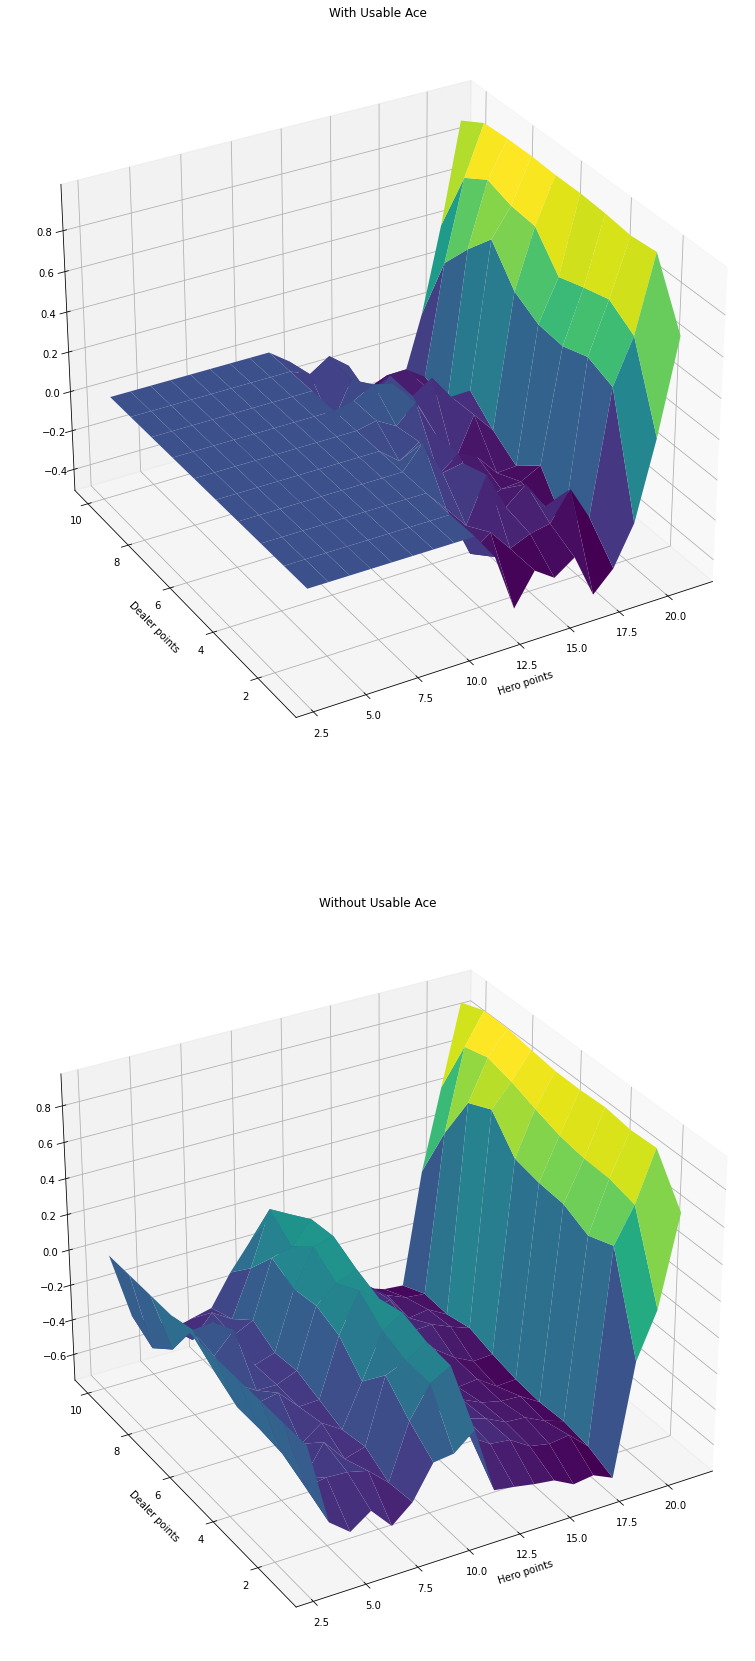

In [14]:
plot3d(V)  

#### Положительные ретерны с такой стратегией только при выпадении нам 19 и выше

#### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
#### Я реализую алгоритм Monte Carlo Control

In [15]:
def get_action_with_eps(Q_s, eps):
    if np.random.random() > eps:
        return np.argmax(Q_s)
    else:
        return np.random.randint(2)

In [16]:
def game_episode_mc_control(Q, eps):
    state = env.reset()[0]
    done = False
    all_states, all_actions, all_rewards = [], [], []
    while True:
        action = get_action_with_eps(Q[state], eps)
        new_state, reward, done, a, b = env.step(action)
        all_states.append(state)
        all_actions.append(action)
        all_rewards.append(reward)
        state = new_state
        if done:
            break
    return all_states, all_actions, all_rewards

In [17]:
def get_strategy_quality(Q, eps=0.0):
    res = []
    for _ in range(int(5e4)):
        states, actions, rewards = game_episode_mc_control(Q, eps)
        res.append(rewards[-1])
    return np.mean(res)

In [18]:
def get_G(rewards, gamma):
    n = len(rewards)
    G = [0 for _ in range(n)]
    G[n - 1] = rewards[n - 1]
    for i in range(n - 2, -1, -1):
        G[i] = rewards[i] + gamma * G[i + 1]
    return G

In [19]:
def monte_carlo_control(n_episodes, gamma, alpha, start_eps, final_eps):
    quality = []
    Q = defaultdict(lambda: np.zeros(2))
    
    eps_step = (start_eps - final_eps) / n_episodes
    eps = start_eps
    for _ in tqdm(range(1, n_episodes + 1)):
        
        if _ % int(5e4) == 0:
            quality.append(get_strategy_quality(Q))
        states, actions, rewards = game_episode_mc_control(Q, eps)
        G = get_G(rewards=rewards, gamma=gamma)
        for i in range(len(states)):
            state = states[i]
            action = actions[i]
            Q[state][action] += alpha * (G[i] - Q[state][action])
            
        eps -= eps_step
        
#     Если состояние незнакомое, то 0(такое скорее всего произойдет только при невозможном состоянии среды)
    pi = defaultdict(lambda: 0)
    for state in Q:
        pi[state] = np.argmax(Q[state])
    return pi, Q, quality

In [20]:
pi, Q, quality = monte_carlo_control(n_episodes=int(1e6), gamma=1.0, alpha=0.01, start_eps=1.0, final_eps=0.01)

  0%|          | 0/1000000 [00:00<?, ?it/s]

0.01000000001513126


In [21]:
V = defaultdict(lambda:0, dict((key, val.max()) for key, val in Q.items()))

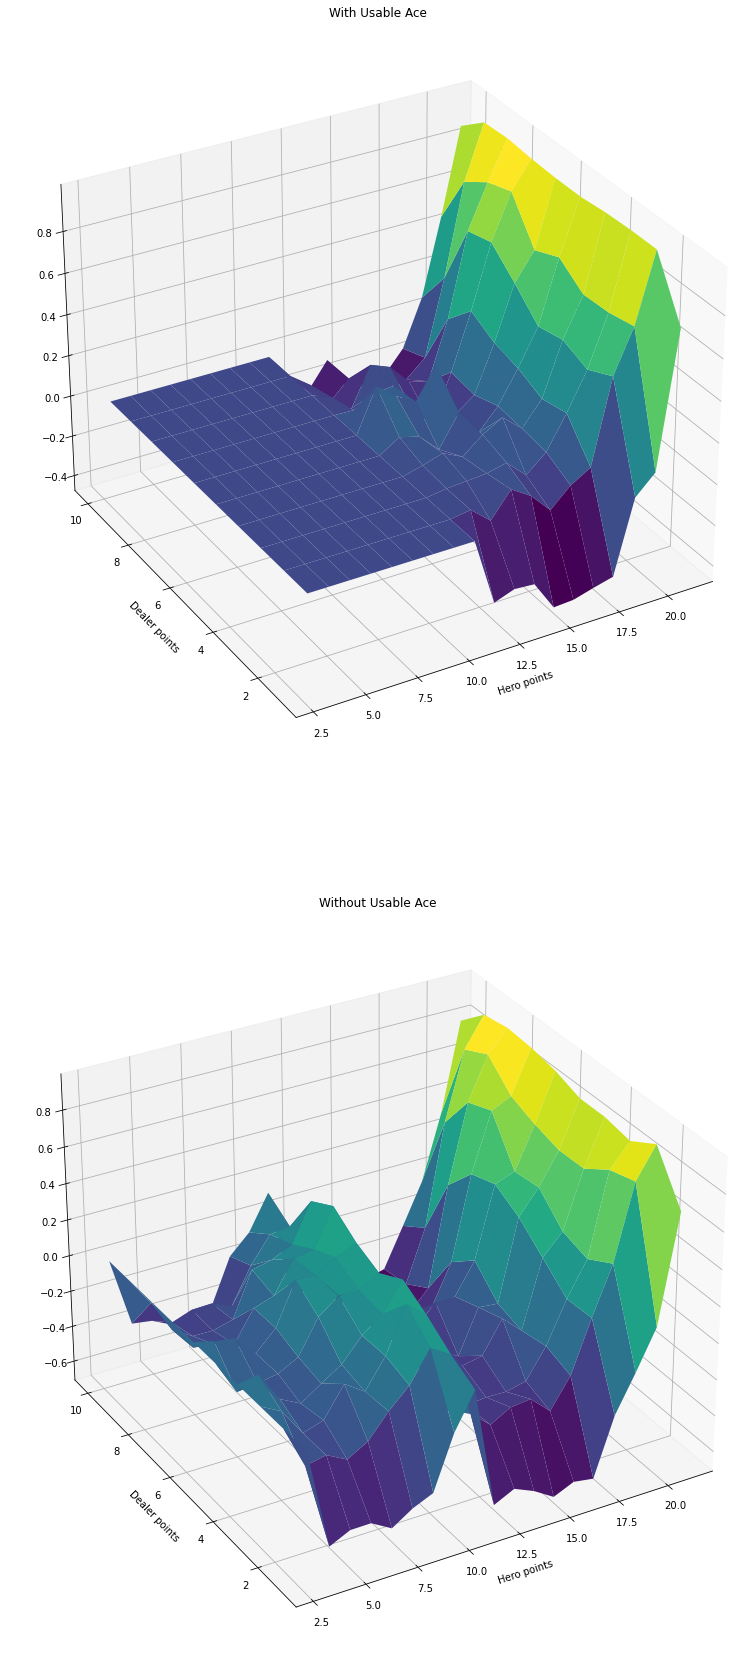

In [22]:
plot3d(V)

#### Здесь видно улучшение ожидания. Например, в старой стратегии было очень плохим решением хитать при 18-ти очках и были плохие ретерны. Здесь же видно, что ситуация при 18-ти, 17-ти и т д явно лучше

#### Визуализируем стратегию

In [30]:
def plot_pi(pi):

    def get_figure(usable_ace, ax):
        x_range = np.arange(4, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[pi[(x, y, usable_ace)] for x in x_range] for y in y_range])
        surf = ax.imshow(Z, vmin=0, vmax=1, extent=[3.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Hero points')
        ax.set_ylabel('Dealer points')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(["0: Stick", "1: Hit"])
            
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

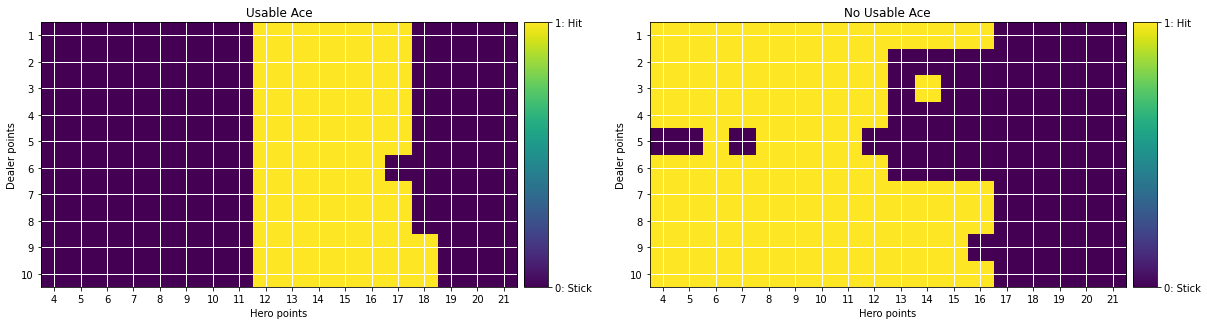

In [31]:
plot_pi(pi)

#### Здесь довольно неплохо то, что алгоритм видеть, что когда у диллера 4, 5 или 6. То необязательно хитать нам, так как у диллера неплохие шансы сгореть самому. Но стоит отметить, что при очках меньших 12, что очевидно надо хитать, алгоритм не понял в некоторых местах. В случаях с usable ace он не хитает при маленьких очках, так как такой ситуации в игре в принципе не существует, а как дефолтное значение стоит 0

#### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Text(0, 0.5, 'average return at 1 game')

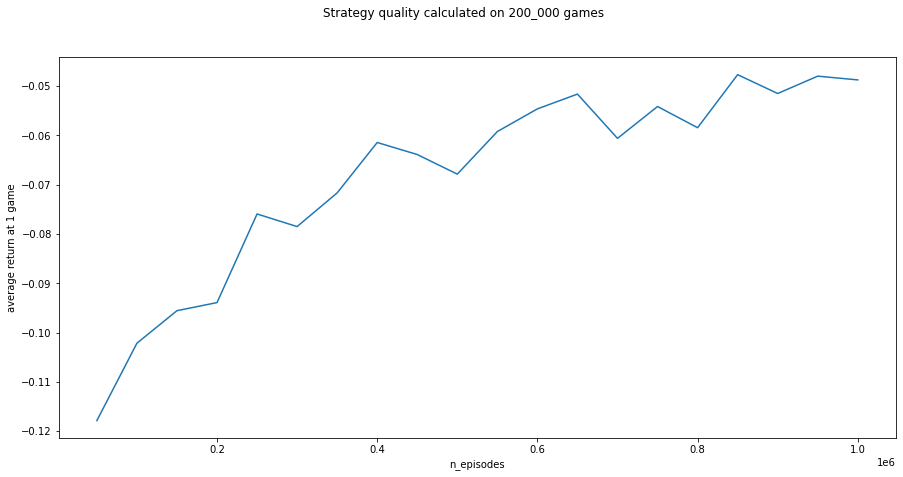

In [32]:
plt.figure(figsize=(15, 7))
plt.plot([int(5e4) * (i + 1) for i in range(len(quality))], quality)
plt.suptitle("Strategy quality calculated on 200_000 games")
plt.xlabel("n_episodes")
plt.ylabel("average return at 1 game")

## Часть вторая, удвоенная

#### 4. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.

#### Можно заметить, что на самом деле double - это hit и затем stick в обязательном порядке, а сумма ставки просто удваивается. Так что необязательно прям переписывать класс из OpenAI Gym

In [15]:
def get_action_with_eps(Q_s, eps):
    if np.random.random() > eps:
        return np.argmax(Q_s)
    else:
        return np.random.randint(3)

In [16]:
def game_episode_mc_control(Q, eps):
    state = env.reset()[0]
    done = False
    all_states, all_actions, all_rewards = [], [], []
    while True:
        action = get_action_with_eps(Q[state], eps)
        if action != 2:
            new_state, reward, done, a, b = env.step(action)
            all_states.append(state)
            all_actions.append(action)
            all_rewards.append(reward)
            state = new_state
            if done:
                break
        else:
            new_state, reward, done, a, b = env.step(1)
            all_states.append(state)
            all_actions.append(action)
            if done:
                all_rewards.append(2 * reward)
                break
            new_state, reward, done, a, b = env.step(0)
            all_rewards.append(2 * reward)
            break
    return all_states, all_actions, all_rewards

#### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [17]:
def get_strategy_quality(Q, eps=0.0):
    res = []
    for _ in range(int(5e4)):
        states, actions, rewards = game_episode_mc_control(Q, eps)
        res.append(rewards[-1])
    return np.mean(res)

In [18]:
def get_G(rewards, gamma):
    n = len(rewards)
    G = [0 for _ in range(n)]
    G[n - 1] = rewards[n - 1]
    for i in range(n - 2, -1, -1):
        G[i] = rewards[i] + gamma * G[i + 1]
    return G

In [19]:
def monte_carlo_control(n_episodes, gamma, start_alpha, final_alpha, start_eps, final_eps):
    quality = []
    Q = defaultdict(lambda: np.zeros(3))
    
    eps_step = (start_eps - final_eps) / n_episodes
    eps = start_eps
    alpha_step = (start_alpha - final_alpha) / n_episodes
    alpha = start_alpha
    for _ in tqdm(range(1, n_episodes + 1)):
        
        if _ % int(5e4) == 0:
            quality.append(get_strategy_quality(Q))
        states, actions, rewards = game_episode_mc_control(Q, eps)
        G = get_G(rewards=rewards, gamma=gamma)
        for i in range(len(states)):
            state = states[i]
            action = actions[i]
            Q[state][action] += alpha * (G[i] - Q[state][action])
            
        eps -= eps_step
        alpha -= alpha_step
#     Если состояние незнакомое, то 0(такое скорее всего произойдет только при невозможном состоянии среды)      
    pi = defaultdict(lambda: 0)
    for state in Q:
        pi[state] = np.argmax(Q[state])
    return pi, Q, quality

In [26]:
pi, Q, quality = monte_carlo_control(n_episodes=int(2e6), gamma=1.0, 
                                     start_alpha=0.03, final_alpha=0.03, 
                                     start_eps=1.0, final_eps=0.01)

  0%|          | 0/2000000 [00:00<?, ?it/s]

In [27]:
V = defaultdict(lambda:0, dict((key, val.max()) for key, val in Q.items()))

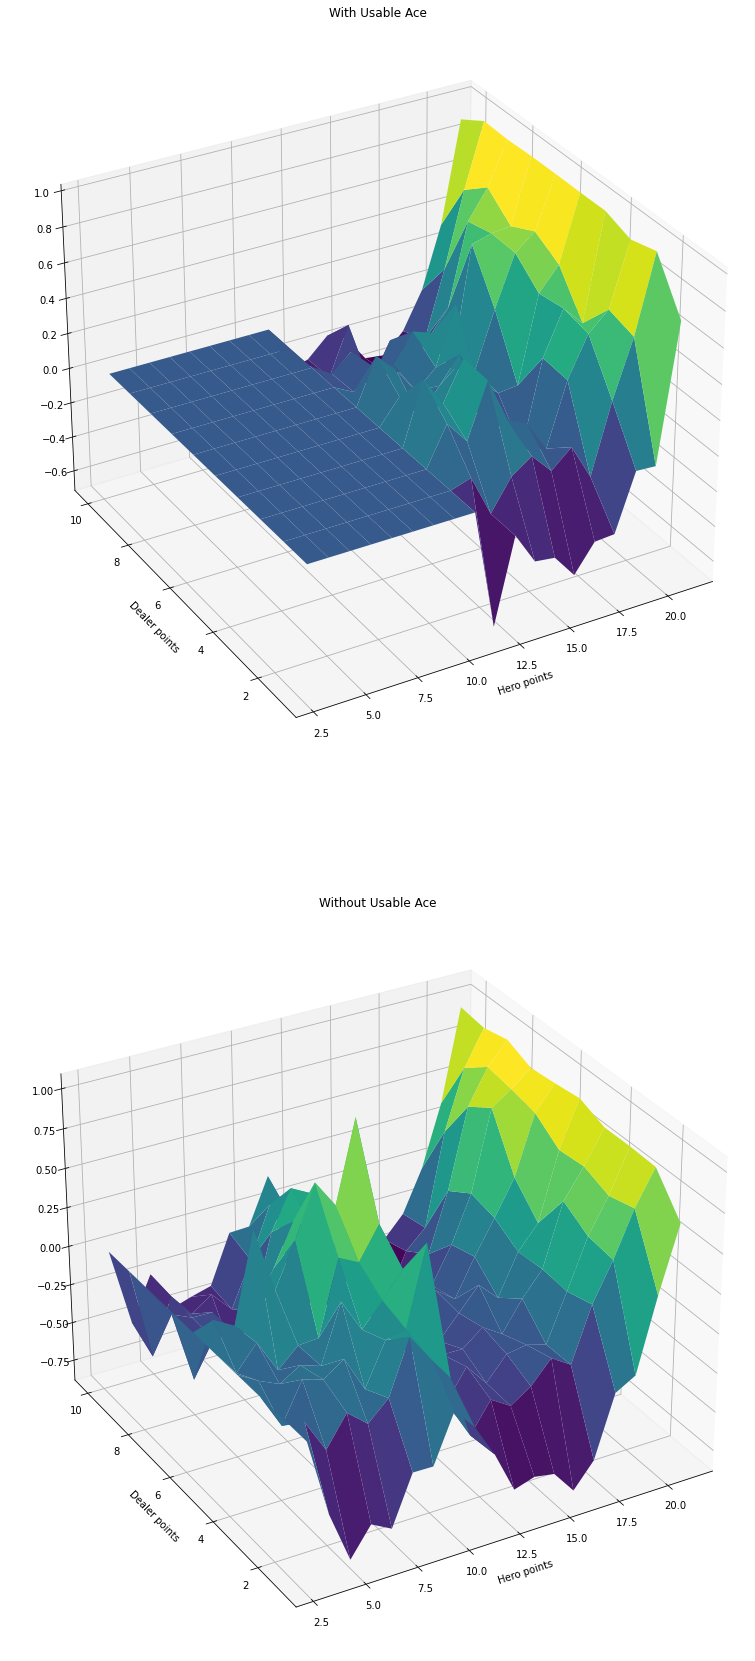

In [28]:
plot3d(V)

#### Здесь видно, что стало выше ожидание при 10-ти и 11-ти очках, так как даблить при 10 и 11 - дело приятное

In [32]:
def plot_pi(pi):

    def get_figure(usable_ace, ax):
        x_range = np.arange(4, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[pi[x,y,usable_ace] for x in x_range] for y in y_range])
        surf = ax.imshow(Z, vmin=0, vmax=2, extent=[3.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Hero points')
        ax.set_ylabel('Dealer points')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1, 2], cax=cax)
        cbar.ax.set_yticklabels(["0 (Stick)", "1 (Hit)", "2 (Double)"])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

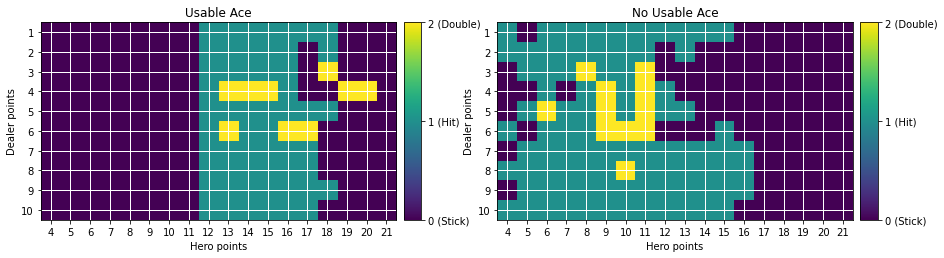

In [33]:
plot_pi(pi)

Text(0, 0.5, 'average return at 1 game')

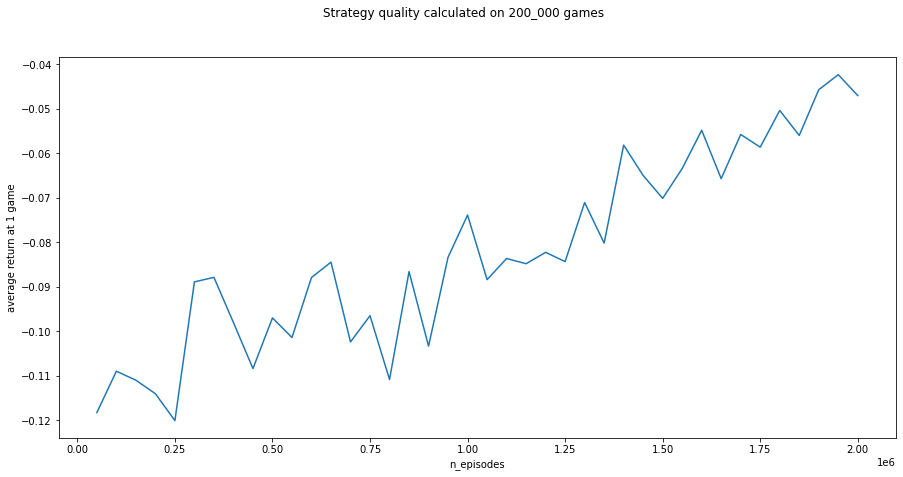

In [34]:
plt.figure(figsize=(15, 7))
plt.plot([int(5e4) * (i + 1) for i in range(len(quality))], quality)
plt.suptitle("Strategy quality calculated on 200_000 games")
plt.xlabel("n_episodes")
plt.ylabel("average return at 1 game")